# 1. import

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1"

os.environ['CUDA_HOME']='/home/j-j11a210/.conda/envs/voice_strength'
os.environ['LD_LIBRARY_PATH']='/home/j-j11a210/.conda/envs/voice_strength/lib'


# 음성 데이터 처리
import librosa
import numpy as np
import pandas as pd

# 데이터 시각화
from matplotlib import pyplot as plt

# 모델 관련
import sklearn
from sklearn import preprocessing # AttributeError: module 'sklearn' has no attribute 'preprocessing'
import tensorflow as tf
# import keras
import joblib

import os
# from datetime import datetime

2024-10-07 17:27:50.105965: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-07 17:27:50.124883: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-07 17:27:50.130489: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-07 17:27:50.144703: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# 2. GPU 인식되는지 확인

In [2]:
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9538576292096583933
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 31192645632
locality {
  bus_id: 1
  links {
  }
}
incarnation: 7465052896924123877
physical_device_desc: "device: 0, name: Tesla V100-PCIE-32GB, pci bus id: 0000:04:00.0, compute capability: 7.0"
xla_global_id: 416903419
]
Num GPUs Available:  1


I0000 00:00:1728289672.085390 1085396 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1728289672.156295 1085396 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1728289672.156944 1085396 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1728289672.325519 1085396 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

# 3. 이것저것 필요한 변수 선언

In [3]:
# sample rate at loaded
SAMPLE_RATE = 16000

# mfcc parameter
N_FFT = 400
HOP_LENGTH = 160
N_MELS = 64

# slicing window parameter
# 입력에 대해 일정 단위로 잘라서 모델에 넣는다.
WINDOW_SECOND = 30
HOP_SECOND = 0

# result data
mfcc_list = []
feature_list = []

model = None

# 4. 데이터 가공 관련 메소드


In [4]:
def load_audio(file_path):
    # 오디오 파일 로드
    assert os.path.isfile(file_path), "Wrong path to audio file"
    amplitude, sr = librosa.load(file_path, sr=SAMPLE_RATE)


    # WINDOW_SECOND가 10s이므로 파일이 10초보다 짧거나 HOP_SECOND의 배수가 아닌 경우 패딩을 추가합니다.
    window_frame = WINDOW_SECOND * SAMPLE_RATE

    if len(amplitude) % window_frame != 0:
      added_frame = window_frame - (len(amplitude) % window_frame)
      amplitude = librosa.util.fix_length(data=amplitude, size=len(amplitude) + added_frame)


    # input audio의 길이가 WINDOW_SECOND 보다 짧은 경우 (480000,)의 1차원 배열
    # print("amplitude shape: " + str(amplitude.shape))

    return amplitude

In [5]:
def extract_mfcc(frame):
    print("frame shape: " + str(frame.shape))
    mfcc = librosa.feature.mfcc(y=frame, sr=SAMPLE_RATE, n_fft=N_FFT, hop_length=HOP_LENGTH, n_mels=N_MELS)

    # (n_mfcc, time_steps)를 전치시켜 시간에 따른 특성을 학습하도록 한다.
    mfcc = mfcc.T
    print("mfcc shape: " + str(mfcc.shape)) # (3001, 20)

    # Z-score로 정규화 후 리턴 (keras의 예제에서도 이 방식을 선택)
    return sklearn.preprocessing.minmax_scale(mfcc, axis=1)

In [6]:
# 슬라이딩 윈도우를 적용해 오디오를 일정 크기의 프레임 단위로 나누는 함수
def audio_sliding_window(file_path, window_second=WINDOW_SECOND, hop_second=HOP_SECOND):
    amplitude = load_audio(file_path)

    # window_second(초)와 hop_second(초)를 샘플 단위로 변환
    window_samples = window_second * SAMPLE_RATE
    hop_samples = window_samples # 이전: hop_second * SAMPLE_RATE

    # 프레임 단위로 오디오를 슬라이딩 윈도우 기법으로 분할
    frame_list = librosa.util.frame(amplitude, frame_length=window_samples, hop_length=window_samples)
    # print("sliced frame shape: " + str(frame_list.shape))

    return frame_list.T

In [7]:
def create_train_set(directory, audio_file_list):
    feature_list = []
    
    # 디렉토리 내 모든 오디오 파일에 대해
    audio_file_count = len(audio_file_list)
    for index, audio_file in enumerate(audio_file_list):
      print(str(index) + "/" + str(audio_file_count) + ": " + audio_file + " pre-prossessing...")


      # 오디오를 WINDOW_SECOND초 단위로 자른다.
      audio_full_path = os.path.join(directory, audio_file)
      frame_list = audio_sliding_window(audio_full_path, WINDOW_SECOND, HOP_SECOND)

      for frame in frame_list:
        new_frame = extract_mfcc(frame)
        feature_list.append(new_frame)
        print("new_frame shape: " + str(new_frame.shape))

    return np.array(feature_list)

---

# Main

## 1) 학습셋 만들기

In [8]:
# 디렉토리에서 wav 파일 목록을 불러온다.
directory = r'/home/j-j11a210/EchoNote/AI/train_data'

audio_full_path_list = []

for (path, dir, files) in os.walk(directory):
    print(path)
    for filename in files:
        if filename.endswith('.wav'):
            audio_full_path_list.append(os.path.join(path, filename))

/home/j-j11a210/EchoNote/AI/train_data
/home/j-j11a210/EchoNote/AI/train_data/.ipynb_checkpoints
/home/j-j11a210/EchoNote/AI/train_data/F0001
/home/j-j11a210/EchoNote/AI/train_data/F0001/.ipynb_checkpoints
/home/j-j11a210/EchoNote/AI/train_data/F0001/NEUTRAL
/home/j-j11a210/EchoNote/AI/train_data/F0001/NEUTRAL/.ipynb_checkpoints
/home/j-j11a210/EchoNote/AI/train_data/M0001
/home/j-j11a210/EchoNote/AI/train_data/M0001/.ipynb_checkpoints
/home/j-j11a210/EchoNote/AI/train_data/M0001/NEUTRAL
/home/j-j11a210/EchoNote/AI/train_data/M0001/NEUTRAL/.ipynb_checkpoints


In [9]:
# 학습셋을 생성한다.
train_set = create_train_set(directory, audio_full_path_list)

0/1998: /home/j-j11a210/EchoNote/AI/train_data/F0001/NEUTRAL/F0001_000899.wav pre-prossessing...
frame shape: (480000,)
mfcc shape: (3001, 20)
new_frame shape: (3001, 20)
1/1998: /home/j-j11a210/EchoNote/AI/train_data/F0001/NEUTRAL/F0001_000151.wav pre-prossessing...
frame shape: (480000,)
mfcc shape: (3001, 20)
new_frame shape: (3001, 20)
2/1998: /home/j-j11a210/EchoNote/AI/train_data/F0001/NEUTRAL/F0001_000529.wav pre-prossessing...
frame shape: (480000,)
mfcc shape: (3001, 20)
new_frame shape: (3001, 20)
3/1998: /home/j-j11a210/EchoNote/AI/train_data/F0001/NEUTRAL/F0001_000060.wav pre-prossessing...
frame shape: (480000,)
mfcc shape: (3001, 20)
new_frame shape: (3001, 20)
4/1998: /home/j-j11a210/EchoNote/AI/train_data/F0001/NEUTRAL/F0001_000359.wav pre-prossessing...
frame shape: (480000,)
mfcc shape: (3001, 20)
new_frame shape: (3001, 20)
5/1998: /home/j-j11a210/EchoNote/AI/train_data/F0001/NEUTRAL/F0001_000816.wav pre-prossessing...
frame shape: (480000,)
mfcc shape: (3001, 20)
ne

In [10]:
train_set.shape

(1998, 3001, 20)

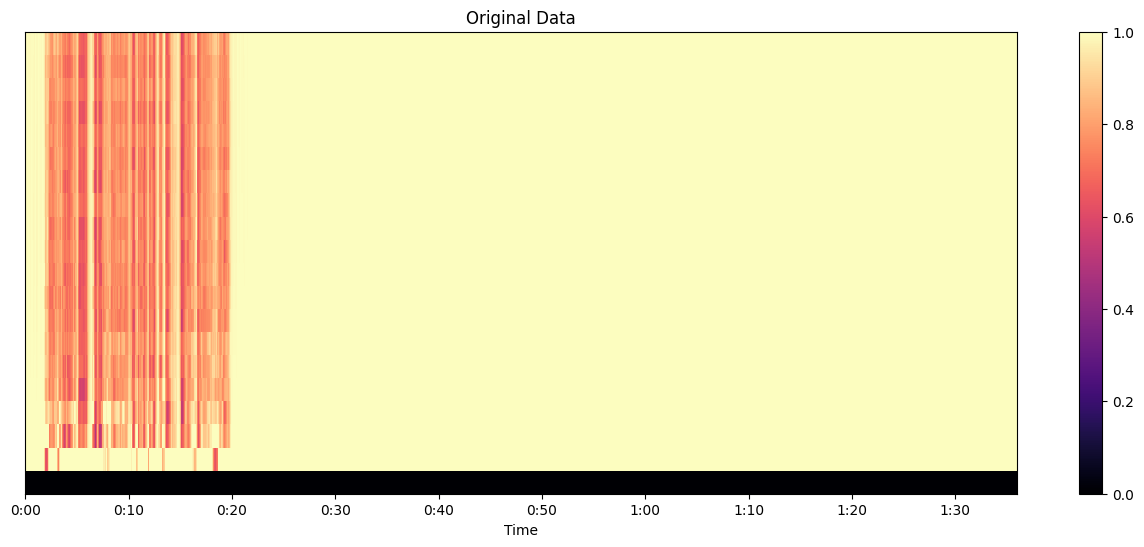

In [11]:
plt.figure(figsize=(16, 6))
librosa.display.specshow(train_set[0].T, sr=SAMPLE_RATE, x_axis='time') # 그릴 때는 전치
plt.title("Original Data")
plt.colorbar()
plt.show()

## 2) 모델 구축 및 학습

In [12]:
def create_autoencoder(input_shape):
    input_layer = tf.keras.layers.Input(shape=input_shape)
    encoded = tf.keras.layers.Dense(128, activation='relu')(input_layer)
    encoded = tf.keras.layers.Dense(64, activation='relu')(encoded)

    decoded = tf.keras.layers.Dense(128, activation='relu')(encoded)
    decoded = tf.keras.layers.Dense(input_shape[1], activation='sigmoid')(decoded)

    autoencoder = tf.keras.models.Model(input_layer, decoded)
    autoencoder.compile(optimizer='adam', loss='mae')

    return autoencoder

In [13]:
# 모델 생성 및 학습
model = create_autoencoder(input_shape=(train_set.shape[1], train_set.shape[2]))

I0000 00:00:1728289790.200914 1085396 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1728289790.201617 1085396 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1728289790.202120 1085396 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1728289790.202702 1085396 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

In [14]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 3001, 20)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3001, 128)      │         2,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3001, 64)       │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3001, 128)      │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3001, 20)       │         2,580 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,844 (85.33 KB)

 Trainable params: 21,844 (85.33 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
train_history = model.fit(
    train_set,
    train_set,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    shuffle=True
)

Epoch 1/50


I0000 00:00:1728289794.791204 1121340 service.cc:146] XLA service 0x7f732804c6f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1728289794.791444 1121340 service.cc:154]   StreamExecutor device (0): Tesla V100-PCIE-32GB, Compute Capability 7.0
2024-10-07 17:29:54.831677: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-07 17:29:54.957431: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 90300


21/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3755

I0000 00:00:1728289796.567093 1121340 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - loss: 0.2647 - val_loss: 0.0276
Epoch 2/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0292 - val_loss: 0.0276
Epoch 3/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0289 - val_loss: 0.0276
Epoch 4/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0288 - val_loss: 0.0276
Epoch 5/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0290 - val_loss: 0.0276
Epoch 6/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0286 - val_loss: 0.0276
Epoch 7/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0284 - val_loss: 0.0276
Epoch 8/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0291 - val_loss: 0.0276
Epoch 9/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0286 - val_loss: 0.0276
Epoch 10/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0289 - val_loss: 0.0275
Epoch 11/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0288 - val_loss: 0.0273
Epoch 12/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0277 - val_l

## 3) 학습 결과 확인

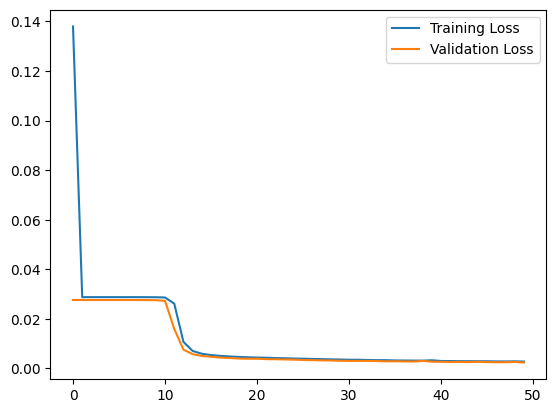

In [16]:
plt.plot(train_history.history["loss"], label="Training Loss")
plt.plot(train_history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

## 4) 재구성 오류 계산을 통한 이상 현상 감지
오토인코더는 입력 데이터를 압축한 후 다시 복원하는 과정을 거친다. **입력 데이터(원본 데이터)**를 인코더로 압축하여 저차원 잠재 공간(z)으로 변환, 그 후, 디코더를 통해 잠재 공간(z)에서 복원된 데이터를 생성한다.

재구성 오류는 입력 데이터와 복원된 데이터 간의 차이를 나타낸다.
재구성 오류(Reconstruction Error)란, 원본 데이터와 오토인코더가 복원한 데이터 간의 차이를 나타내는 값으로, 오토인코더가 원본 데이터를 얼마나 잘 복원했는지를 나타낸다.

정상적인 데이터는 오토인코더가 잘 복원할 수 있어 재구성 오류가 작다. 오토인코더가 학습에 사용한 정상적인 패턴에 가까운 데이터를 입력하면 복원 과정에서 큰 손실 없이 재구성할 수 있다.

반면, 이상치 데이터는 복원이 잘 되지 않아 재구성 오류가 크다. 이상치는 학습 중에 경험하지 못한 패턴일 가능성이 높으므로, 오토인코더가 이를 잘 복원하지 못해 큰 오류가 발생한다.

---

### 그래프에 대한 설명
각 loss에 대한 데이터 수를 의미하는 것 같다. loss가 0.00에 가까운 sample이 대다수임을 볼 수 있다. 또한 이상 경계값인 0.04를 넘는 샘플이 거의 없다. 이런 이유로 해당 데이터에서 anomaly가 발견되지 않았다고 할 수 있다?

In [17]:
# mae loss를 계산해보자.

# 모델을 이용해 입력 데이터를 복원한다.
train_pred = model.predict(train_set)

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


In [18]:
train_pred.shape

(1998, 3001, 20)

(array([2.352e+03, 4.400e+01, 3.300e+01, 3.900e+01, 4.000e+01, 6.100e+01,
        6.000e+01, 7.600e+01, 7.800e+01, 7.000e+01, 5.000e+01, 2.100e+01,
        1.700e+01, 1.300e+01, 1.000e+01, 9.000e+00, 3.000e+00, 5.000e+00,
        4.000e+00, 1.000e+00, 3.000e+00, 1.000e+00, 1.000e+00, 2.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 2.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00]),
 array([0.00010424, 0.00208384, 0.00406344, 0.00604304, 0.00802264,
        0.01000224, 0.01198183, 0.01396143, 0.01594103, 0.01792063,
        0.01990023, 0.02187983, 0.02385942, 0.02583902, 0.02781862,
        0.02979822, 0.03177781, 0.03375741, 0.03573701, 0.03771661,
        0.03969621, 0.04167581, 0.0436554 , 0.045635  , 0.0476146 ,
        0.0495942 , 0.0515738 , 0.05

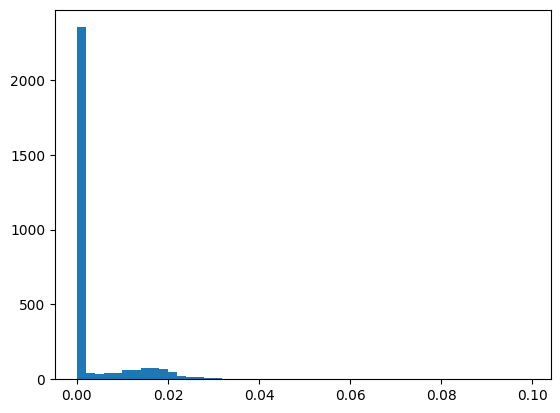

In [19]:
# 모델이 복원한 결과와 실제 원본값의 차이를 계산한다.
# 차이가 클수록 오토인코더가 복원하는 데 어려움을 겪었다는 의미
# == 해당 데이터가 이상치일 가능성이 있다는 의미
# ↓↓↓↓↓↓ 생각보다 오래걸림
train_mae_loss = np.mean(np.abs(train_pred - train_set), axis=-1)

# ?
plt.hist(train_mae_loss[0], bins=50)
# plt.xlabel("Train mae loss")
# plt.ylabel("mae samples")
# plt.show()

In [20]:
train_mae_loss.shape

(1998, 3001)

## 5) 재구성이 잘 되었는지 시각화하여 보기

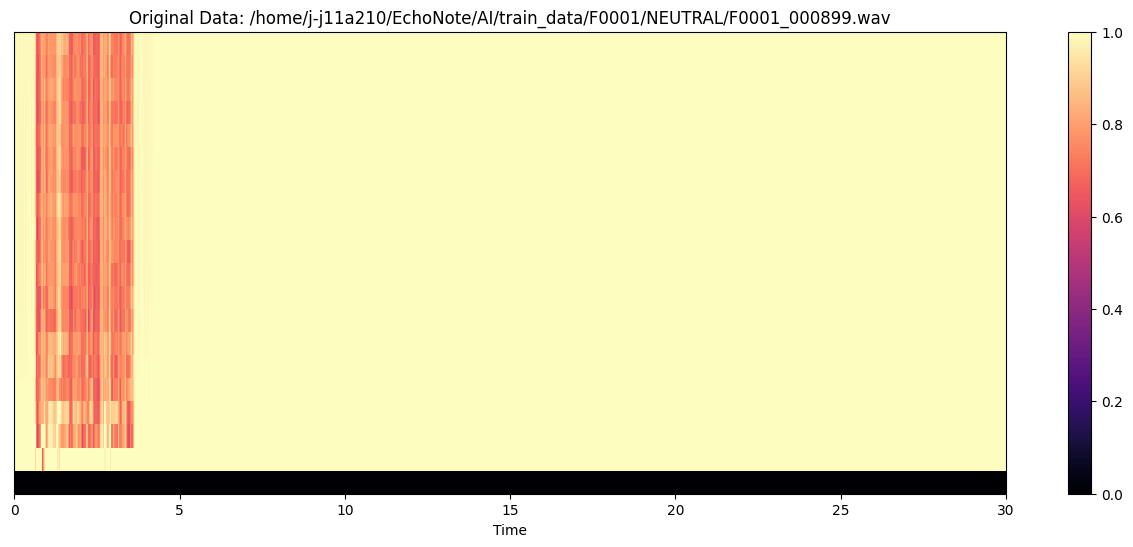

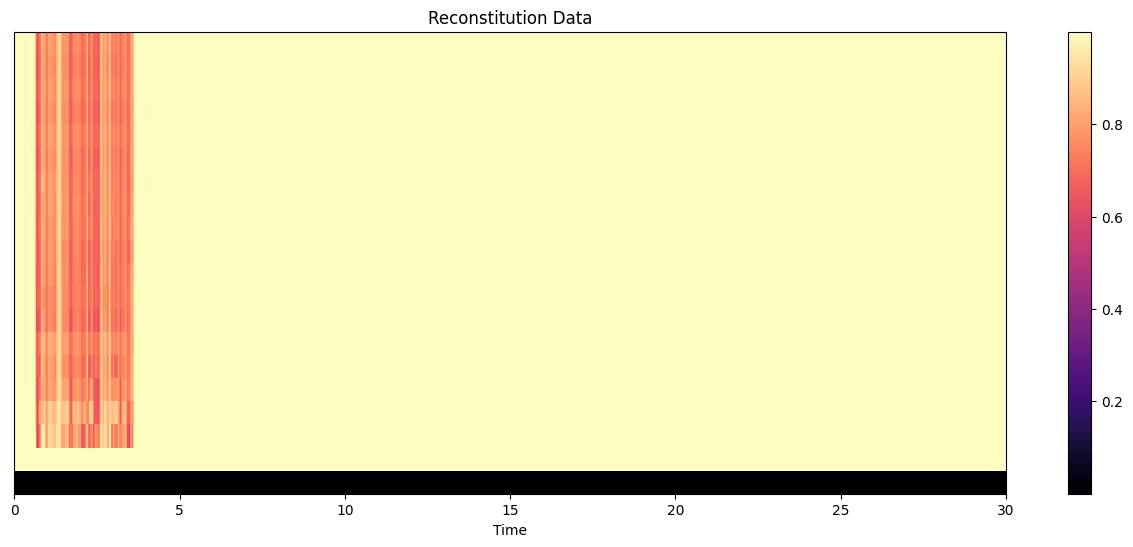

In [21]:
'''
mfcc라서 그냥 matplotlib으로 바로 그리면 안 되고
librosa.display.specshow 메서드를 써서 그려야 한다.
keras의 예제는 mfcc를 쓰지 않았기에 그냥 matplotlib으로 그린 것.
'''

plt.figure(figsize=(16, 6))
librosa.display.specshow(train_set[100].T, sr=SAMPLE_RATE, x_axis='time', hop_length=HOP_LENGTH, n_fft=N_FFT)
plt.title('Original Data: {}'.format(audio_full_path_list[0]))
plt.colorbar()
plt.show()


plt.figure(figsize=(16, 6))
librosa.display.specshow(train_pred[100].T, sr=SAMPLE_RATE, x_axis='time', hop_length=HOP_LENGTH, n_fft=N_FFT)
plt.title("Reconstitution Data")
plt.colorbar()
plt.show()

## 6) 이상 탐지 임계값 설정
평균 재구성 오류에 3배의 표준편차를 더한 값을 임계값으로 사용한다?

통계적으로 정규 분포를 가정하면, 평균 ± 3표준편차 안에 약 99.7%의 데이터가 포함된다? 즉, 정상적인 범위는 평균 재구성 오류에서 3표준편차 내의 값이라고 볼 수 있으며, 그보다 큰 값들은 이상치로 간주할 수 있다?

In [22]:
train_mae_loss.shape

(1998, 3001)

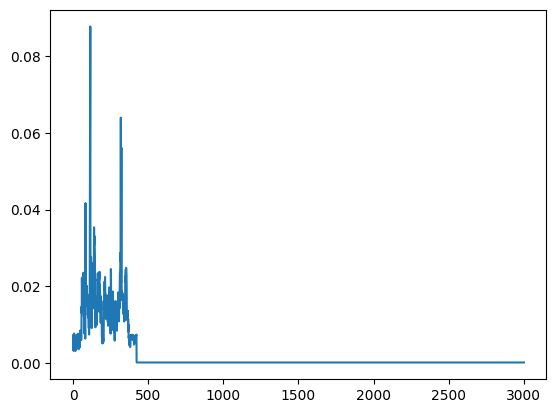

In [99]:
plt.plot(train_mae_loss[5])

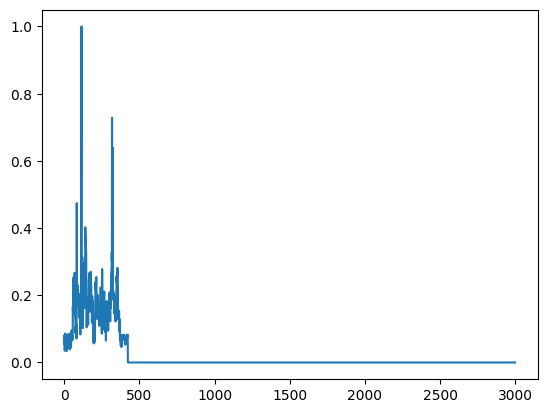

In [100]:
plt.plot(sklearn.preprocessing.minmax_scale(train_mae_loss[5], axis=0))

In [ ]:
train_mae_loss

In [67]:
## 일반적인 방식
# # Get reconstruction loss threshold.
# threshold = np.mean(train_mse_loss) + 3 * np.std(train_mse_loss)
# print("Reconstruction error threshold: ", threshold)

threshold_mean = np.mean(train_mae_loss, axis=-1) + 3 * np.std(train_mae_loss)
threshold_max = np.max(train_mae_loss)
print("Reconstruction error threshold_mean: ", threshold_mean)
print("Reconstruction error threshold_max: ", threshold_max)

Reconstruction error threshold_mean:  [0.02270385 0.02393991 0.02231085 ... 0.02127151 0.02086229 0.02236066]
Reconstruction error threshold_max:  0.11855171


In [26]:
## 각 차원에 대한 임계값 설정
# 임계값은 세로 방향으로 계산해야 한다.
thresholds = np.mean(train_mae_loss, axis=0) + 3 * np.std(train_mae_loss, axis=0)
print("Reconstruction error thresholds: ", thresholds)

Reconstruction error thresholds:  [0.01190349 0.01172611 0.01266062 ... 0.00010428 0.00010428 0.00010428]


In [28]:
# 각 time frame 마다 임계값이 생성되었음을 확인
thresholds.shape

(3001,)

## 7) 모델 저장

In [29]:
# @keras.saving.register_keras_serializable()
model.save(r'/home/j-j11a210/EchoNote/AI/audio_anomaly_detection_mae.keras')

---

In [88]:
# 실 데이터 불러오기
test_data = create_train_set(r'/home/j-j11a210/EchoNote/AI', ['hanseokwon44k.wav'])
test_data.shape

0/1: hanseokwon44k.wav pre-prossessing...
frame shape: (480000,)
mfcc shape: (3001, 20)
new_frame shape: (3001, 20)
frame shape: (480000,)
mfcc shape: (3001, 20)
new_frame shape: (3001, 20)
frame shape: (480000,)
mfcc shape: (3001, 20)
new_frame shape: (3001, 20)
frame shape: (480000,)
mfcc shape: (3001, 20)
new_frame shape: (3001, 20)
frame shape: (480000,)
mfcc shape: (3001, 20)
new_frame shape: (3001, 20)


(5, 3001, 20)

In [89]:
test_predict_list = model.predict(test_data, batch_size=32)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


In [90]:
test_predict_list.shape

(5, 3001, 20)

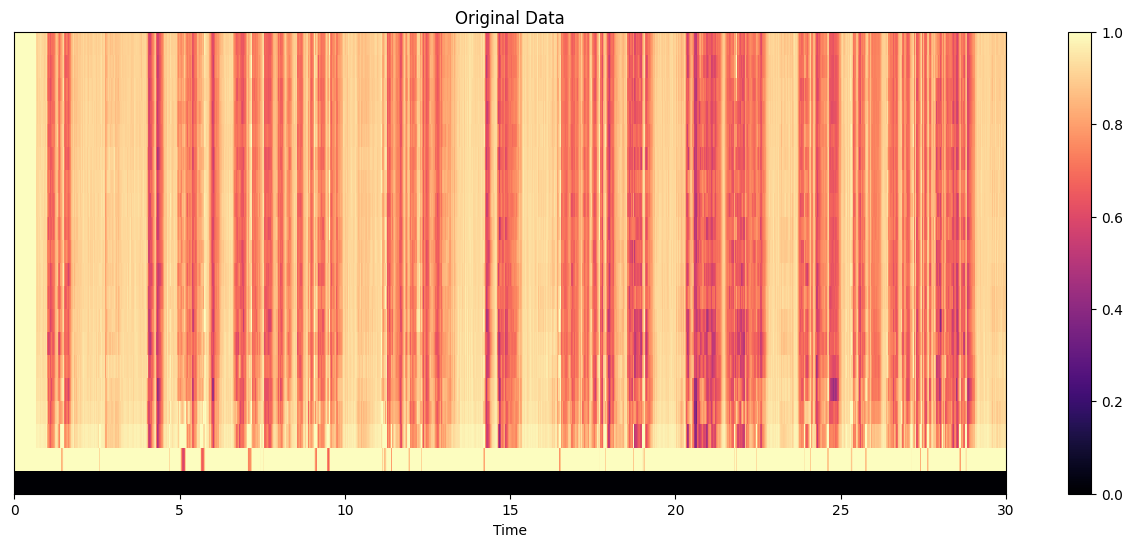

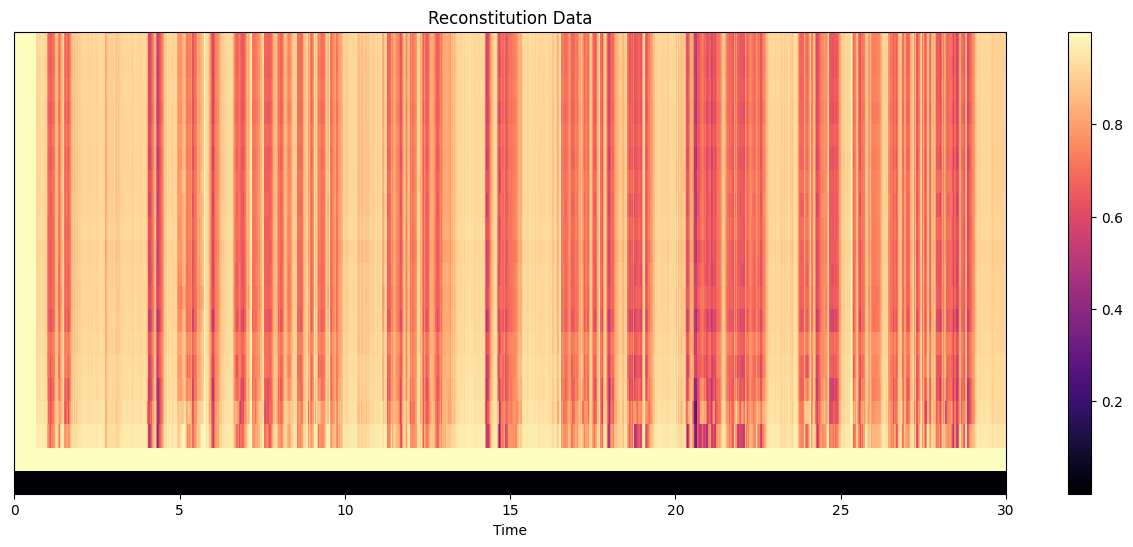

In [91]:
plt.figure(figsize=(16, 6))
librosa.display.specshow(test_data[0].T, sr=SAMPLE_RATE, x_axis='time', hop_length=HOP_LENGTH, n_fft=N_FFT)
plt.title('Original Data')
plt.colorbar()
plt.show()


plt.figure(figsize=(16, 6))
librosa.display.specshow(test_predict_list[0].T, sr=SAMPLE_RATE, x_axis='time', hop_length=HOP_LENGTH, n_fft=N_FFT)
plt.title("Reconstitution Data")
plt.colorbar()
plt.show()

In [92]:
mae_loss_list = np.mean(np.abs(test_data - test_predict_list), axis=-1) # (n, 3001)
print(mae_loss_list.shape)

(5, 3001)


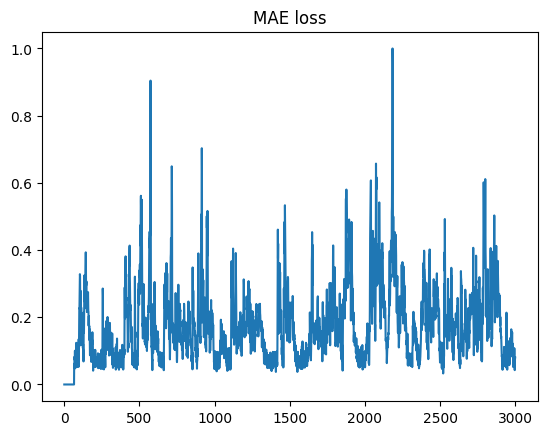

In [93]:
plt.title("MAE loss")
plt.plot(sklearn.preprocessing.minmax_scale(mae_loss_list[0], axis=0))
# plt.axhline(y=threshold_max, color='r', linewidth=1)
# plt.axhline(y=threshold_mean, color='g', linewidth=1)
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


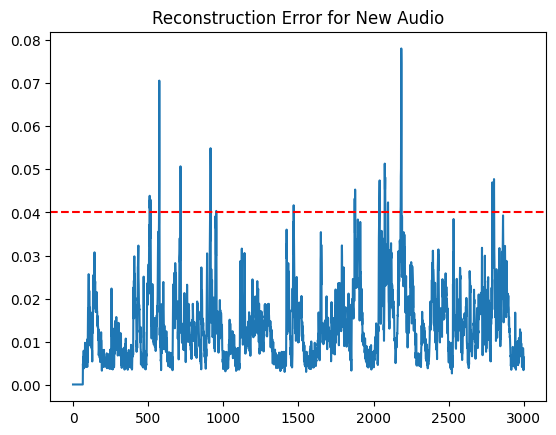

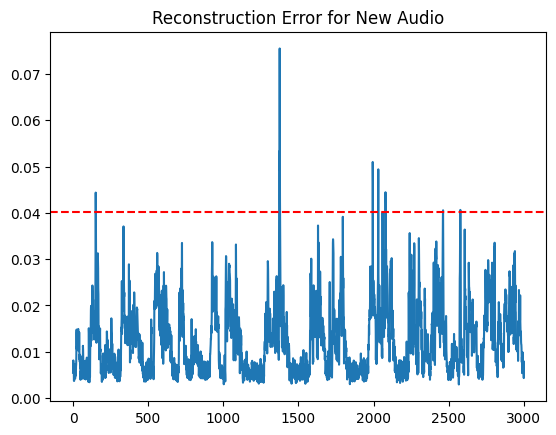

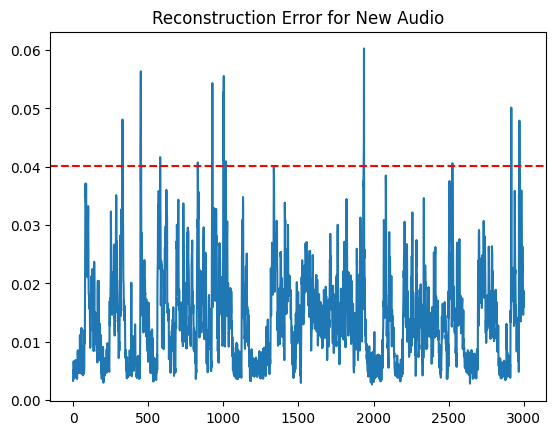

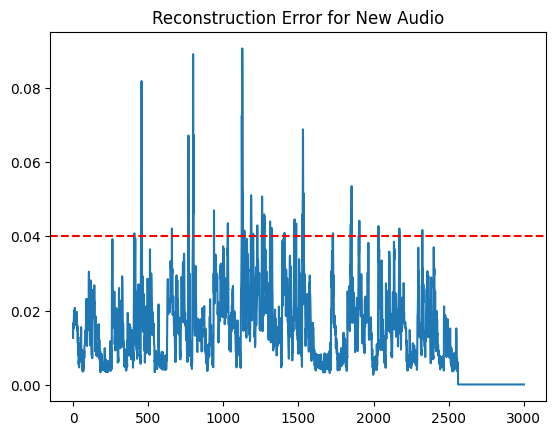

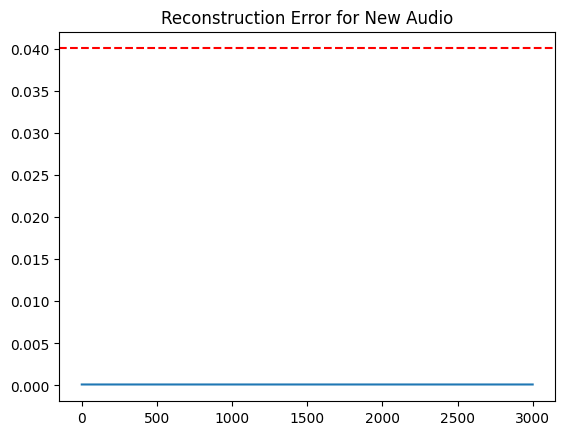

In [94]:
test_predict = model.predict(test_data)
test_mae_loss = np.mean(np.abs(test_predict - test_data), axis=-1)
test_threshold = np.mean(test_mae_loss) + 3 * np.std(test_mae_loss)

# librosa.display.specshow(, sr=SAMPLE_RATE, x_axis='time')
for time_frame in test_mae_loss:
    plt.plot(time_frame)
    plt.axhline(y=test_threshold, color='r', linestyle='--')
    plt.title('Reconstruction Error for New Audio')
    plt.show()

In [ ]:
test_mae_loss

In [ ]:
# 7. 이상치 탐지
print(test_mae_loss.shape)
print("loss: ", test_mae_loss)
anomalies_new = np.where(test_mae_loss > threshold)[0]
print("Detected anomalies at:", anomalies_new)

# 8. 이상치가 발생한 시점 출력
# 예를 들어 이상치가 발생한 프레임이 몇 초인지 계산
frame_duration = len(test_data) / len(test_mae_loss)  # 한 프레임이 차지하는 시간 비율 계산
anomalous_times = anomalies_new * frame_duration
print("Anomalies detected at (seconds):", anomalous_times)

In [ ]:
# test_predict = model.predict(test_data)
# test_mae_loss = np.mean(np.power(test_predict - test_data, 2), axis=1)
# threshold = np.mean(test_mae_loss) + 3 * np.std(test_mae_loss)

# # librosa.display.specshow(, sr=SAMPLE_RATE, x_axis='time')
# for time_frame in test_mae_loss:
#     plt.plot(time_frame)
#     plt.axhline(y=threshold, color='r', linestyle='--')
#     plt.title('Reconstruction Error for New Audio')
#     plt.show()

# 타임스탬프 생성 (예: 1초 간격의 타임스탬프)
timestamps = pd.date_range(start='2024-10-01', periods=len(test_mae_loss), freq='S')

# 각 차원에 대한 이상치 탐지
anomalies = np.any(test_mae_loss > thresholds, axis=1)

# 이상치가 발생한 시각 추출
anomaly_timestamps = timestamps[anomalies]

# 결과 출력
print("Detected anomalies in test data:", anomalies)
print("Number of anomalies detected:", np.sum(anomalies))
print("Timestamps of detected anomalies:", anomaly_timestamps)

# 이상치 시각화
plt.figure(figsize=(12, 6))
for i in range(20):  # 13개의 MFCC 계수에 대한 시각화
    plt.subplot(4, 5, i + 1)  # 3x5 서브플롯
    plt.hist(test_mae_loss[:, i], bins=30, alpha=0.7, color='blue', edgecolor='black')
    plt.axvline(x=thresholds[i], color='red', linestyle='--', label='Threshold')
    plt.title(f'MFCC {i + 1}')
    plt.xlabel('Reconstruction Error')
    plt.ylabel('Frequency')
    plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
def sec_to_timestamp(sec):
    hour = sec // (60*60)
    sec %= 60*60

    minute = sec // 60
    sec %= 60

    return '%02d:%02d:%02d' % (hour, minute, sec)